In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import keras.backend as K
import tensorflow as tf
import pandas as pd
import numpy as np

#callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint

In [2]:
data_path=r'C:\\Users\\HP\\Desktop\\project\\Code\\Rice leaf disease_1\\Training data 1'

In [3]:
# System libraries
from pathlib import Path
import os.path

image_dir = Path(data_path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df.head(5)

,Filepath,Label
0,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight
1,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight
2,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight
3,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight
4,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight


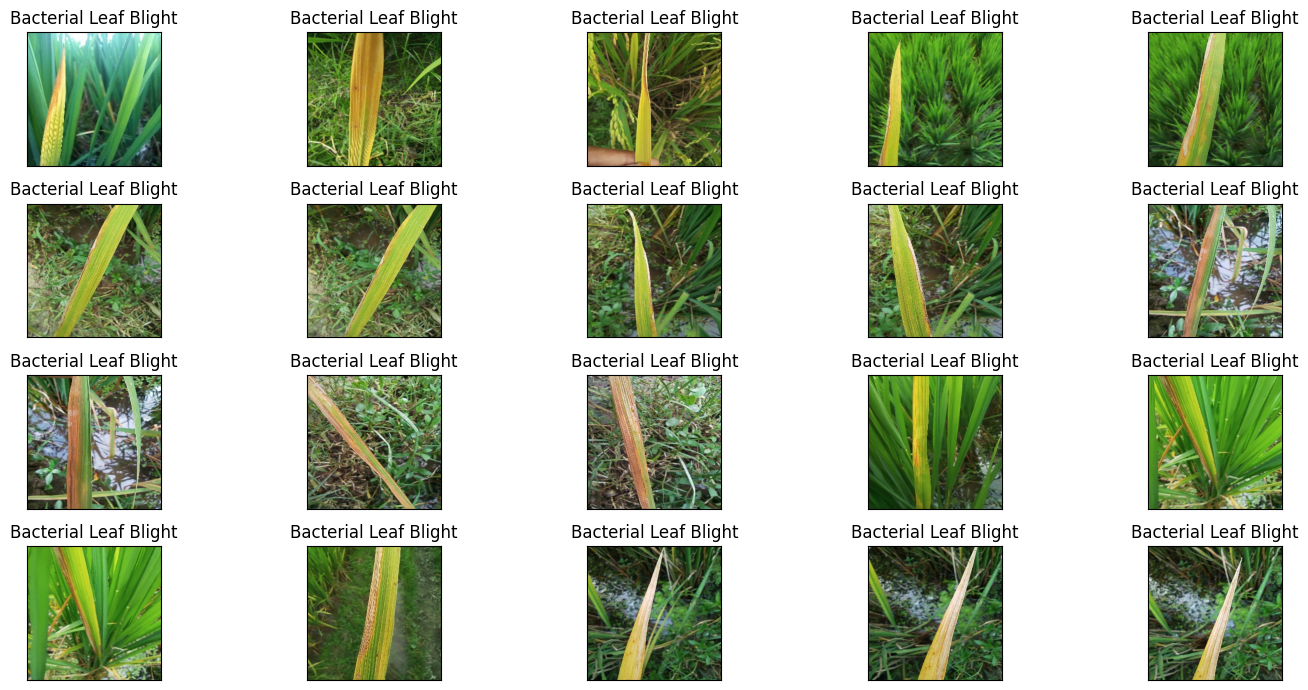

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
training_df,testing_df=train_test_split(image_df,test_size=0.2,shuffle=True,random_state=1)

print('The dimension of training data :',training_df.shape)
print('The dimension of testing data :',testing_df.shape)

The dimension of training data : (3054, 2)
The dimension of testing data : (764, 2)


In [5]:
training_generator=ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
testing_generator=ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

training_images=training_generator.flow_from_dataframe(

    dataframe=training_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(250, 250),    
    color_mode='rgb',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
    
)


validation_images=training_generator.flow_from_dataframe(


    dataframe=training_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(250,250),
    color_mode='rgb',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'

)


testing_images=testing_generator.flow_from_dataframe(


    dataframe=testing_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(250,250),
    color_mode='rgb',
    batch_size=16,
    shuffle=False,
)



Found 2444 validated image filenames belonging to 8 classes.
Found 610 validated image filenames belonging to 8 classes.
Found 764 validated image filenames belonging to 8 classes.


In [20]:
early_stopping=EarlyStopping(monitor='val_loss',patience=5,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=0,factor=0.1)

model_check_point=ModelCheckpoint(monitor='val_accuracy',filepath='./bestmodel.h5',save_best_only=True,verbose=True)

In [21]:
epochs=20
batch_size=16

nb_train_samples = training_images.samples
nb_validation_samples = validation_images.samples

## Inception

In [6]:
#transfer learning
from keras.applications.inception_v3 import InceptionV3

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

for layer in base_model.layers:
    layer.trainable=False

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 batch_normalization_189 (Ba  (None, 6, 6, 2048)       8192      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_3 (Dropout)         (None, 1024)             

In [27]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_192 (Conv2D)            (None, 124, 124, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_190 (Batch  (None, 124, 124, 32  96         ['conv2d_192[0][0]']             
 Normalization)                 )                                                           

In [28]:
import time
# Record the start time of training
start_time = time.time()

In [29]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(
    
    training_images,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_images,
    epochs=epochs,
    batch_size=batch_size,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[early_stopping,reduce_lr,model_check_point]

)

Epoch 1/20
152/152 [==============================] - ETA: 0s - loss: 2.2726 - accuracy: 0.1705
Epoch 1: val_accuracy improved from -inf to 0.17599, saving model to .\bestmodel.h5
152/152 [==============================] - 76s 458ms/step - loss: 2.2726 - accuracy: 0.1705 - val_loss: 2.2945 - val_accuracy: 0.1760 - lr: 0.0010
Epoch 2/20
152/152 [==============================] - ETA: 0s - loss: 2.0704 - accuracy: 0.2245
Epoch 2: val_accuracy improved from 0.17599 to 0.32072, saving model to .\bestmodel.h5
152/152 [==============================] - 66s 432ms/step - loss: 2.0704 - accuracy: 0.2245 - val_loss: 1.8145 - val_accuracy: 0.3207 - lr: 0.0010
Epoch 3/20
152/152 [==============================] - ETA: 0s - loss: 1.8315 - accuracy: 0.2990
Epoch 3: val_accuracy improved from 0.32072 to 0.39638, saving model to .\bestmodel.h5
152/152 [==============================] - 73s 476ms/step - loss: 1.8315 - accuracy: 0.2990 - val_loss: 1.6591 - val_accuracy: 0.3964 - lr: 0.0010
Epoch 4/20
15

In [30]:
# Record the training end time
end_time = time.time()

In [31]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 1317.0654556751251 seconds


In [32]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,2.272638,0.170511,2.294484,0.175987,0.001
1,2.070405,0.224465,1.814546,0.320724,0.001
2,1.831487,0.299012,1.659141,0.396382,0.001
3,1.683584,0.365321,1.520798,0.452303,0.001
4,1.552812,0.415980,1.441874,0.460526,0.001
5,1.490217,0.448517,1.602868,0.452303,0.001
6,1.554738,0.406919,1.641234,0.416118,0.001
7,1.457243,0.437397,1.372879,0.509868,0.001
8,1.384456,0.483114,1.251101,0.572368,0.001
9,1.295578,0.521829,1.490324,0.493421,0.001


In [33]:
import joblib
joblib.dump(history.history,'history_inception_best_1.pkl')
history_CNN3 = joblib.load('history_inception_best_1.pkl')

In [34]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.tight_layout()

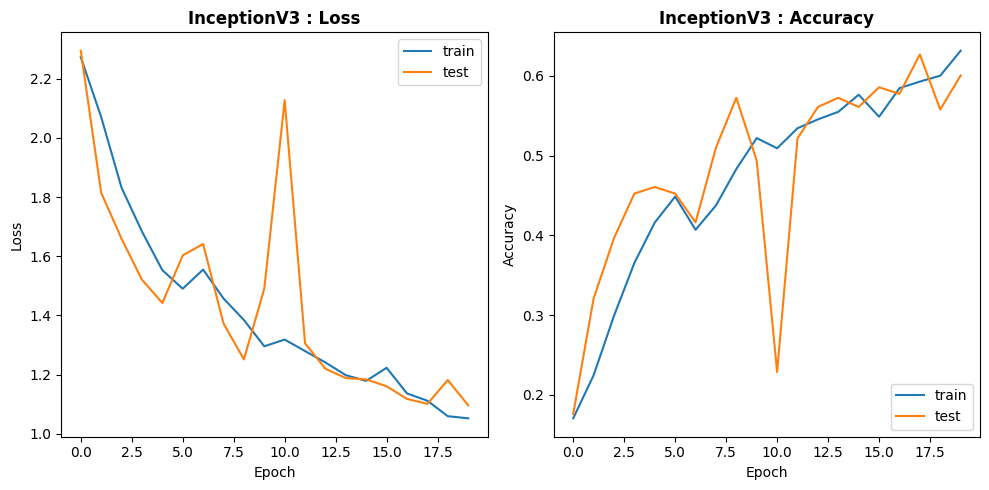

In [35]:
plot_performance(model_name='InceptionV3',
                acc=history_CNN3['accuracy'], 
                 val_acc=history_CNN3['val_accuracy'],
                 loss=history_CNN3['loss'], 
                 val_loss=history_CNN3['val_loss'])

In [36]:
from keras.models import load_model

model=load_model('bestmodel.h5')

In [37]:
Evaluation=model.evaluate(testing_images)


print("Test Accuracy: {:.2f}%".format(Evaluation[1] * 100))
print("Test Loss: {:.5f}".format(Evaluation[0]))

48/48 [==============================] - 15s 274ms/step - loss: 1.0780 - accuracy: 0.6113
Test Accuracy: 61.13%
Test Loss: 1.07799


In [38]:
val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()


score = model.evaluate(validation_images)
val_loss.append(score[0])
val_accuracy.append(score[1])
print('\nVal loss:', score[0])
print('Val accuracy:', score[1])

score = model.evaluate(testing_images)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

test_loss.append(score[0])
test_accuracy.append(score[1])

39/39 [==============================] - 10s 256ms/step - loss: 1.0974 - accuracy: 0.6213

Val loss: 1.0973526239395142
Val accuracy: 0.6213114857673645
48/48 [==============================] - 13s 268ms/step - loss: 1.0837 - accuracy: 0.6230

Test loss: 1.0837458372116089
Test accuracy: 0.6230366230010986


In [39]:
prediction=model.predict(testing_images)
prediction=np.argmax(prediction,axis=1)

48/48 [==============================] - 12s 222ms/step


In [40]:
training_images.class_indices

{'Bacterial Leaf Blight': 0,
 'Brown Spot': 1,
 'Healthy Rice Leaf': 2,
 'Leaf Blast': 3,
 'Leaf scald': 4,
 'Narrow Brown Leaf Spot': 5,
 'Rice Hispa': 6,
 'Sheath Blight': 7}

In [41]:
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

In [42]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

48/48 [==============================] - 10s 211ms/step
Classification Report
                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.59      0.49      0.54        81
            Brown Spot       0.58      0.77      0.66       107
     Healthy Rice Leaf       0.67      0.90      0.77        73
            Leaf Blast       0.60      0.52      0.56       142
            Leaf scald       0.46      0.61      0.52        94
Narrow Brown Leaf Spot       0.00      0.00      0.00        59
            Rice Hispa       0.74      0.84      0.79        96
         Sheath Blight       0.87      0.75      0.80       112

              accuracy                           0.63       764
             macro avg       0.56      0.61      0.58       764
          weighted avg       0.59      0.63      0.61       764



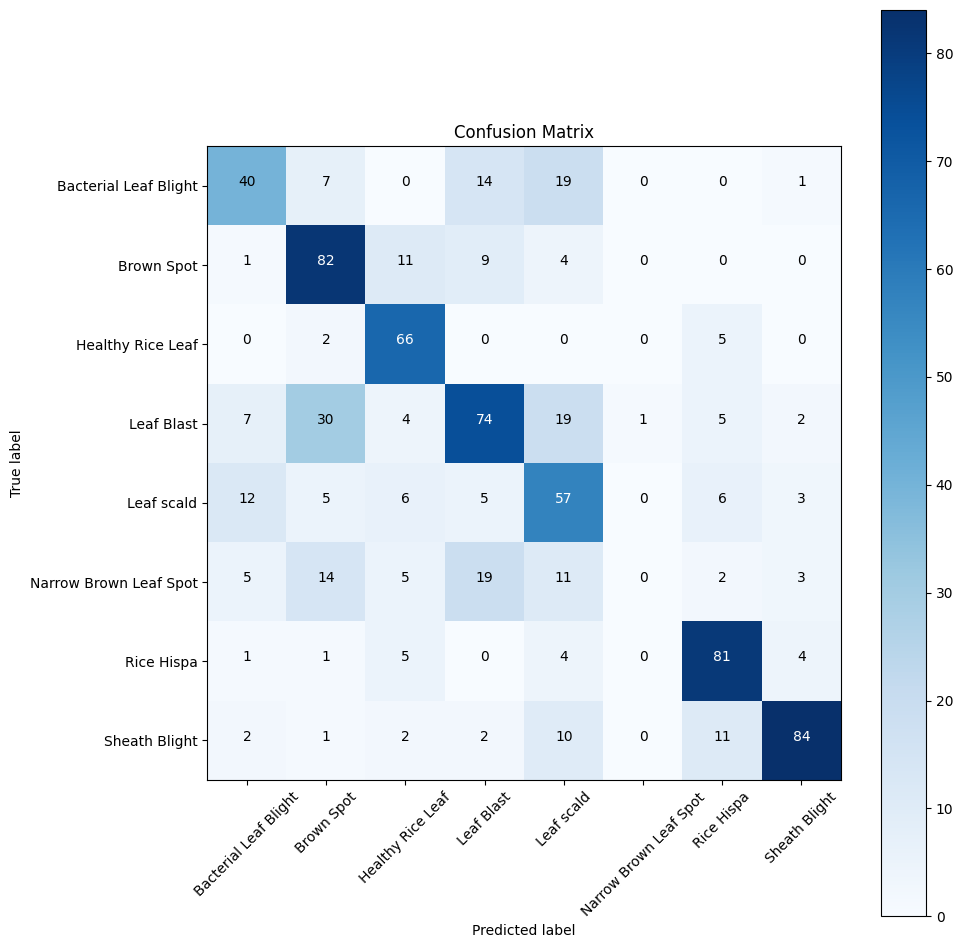

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict(testing_images)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
classes = list(training_images.class_indices.keys())
target_names = classes

#Confution Matrix
cm = confusion_matrix(testing_images.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(testing_images.classes, y_pred, target_names=target_names, zero_division=1))

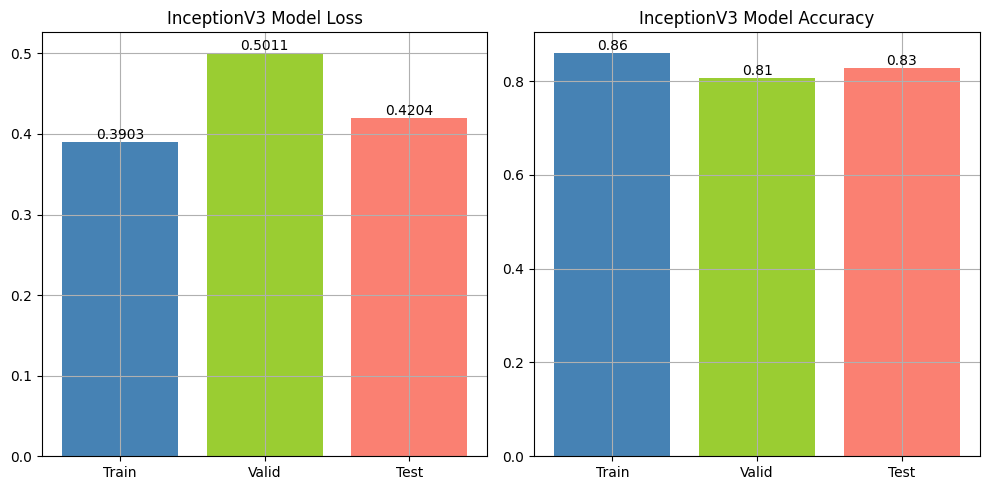

In [20]:
# Visualizing Model Performance
loss_values = [0.390253, 0.5010952353477478, 0.420370489358902]  
accuracy_values = [0.860714, 0.8071428537368774, 0.8276515007019043] 

plt.figure(figsize=(10, 5))  
  
# 第一个子图：模型损失  
plt.subplot(1, 2, 1)  
plt.title("InceptionV3 Model Loss")  
plt.bar(["Train", "Valid", "Test"], loss_values,color=['steelblue', 'yellowgreen', 'salmon'])  
  
# 为模型损失的每个条形添加数字标签  
for index, value in enumerate(loss_values):  
    plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')  
  
plt.grid()  
  
# 第二个子图：模型准确率  
plt.subplot(1, 2, 2)  
plt.title("InceptionV3 Model Accuracy")  
plt.bar(["Train", "Valid", "Test"], accuracy_values, color=['steelblue', 'yellowgreen', 'salmon'])  
  
# 为模型准确率的每个条形添加数字标签  
for index, value in enumerate(accuracy_values):  
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')  
  
plt.grid()  
  
# 显示图表  
plt.tight_layout()  # 确保子图之间不会重叠  
plt.show()

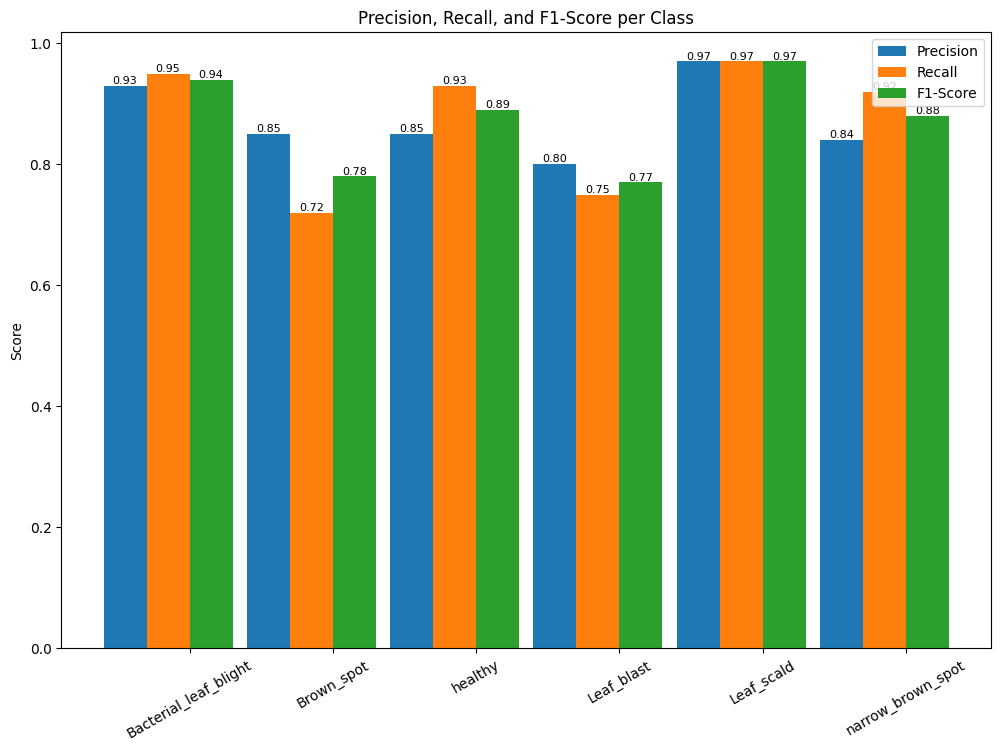

In [26]:
data = [['Bacterial_leaf_blight', 0.93, 0.95, 0.94],  
         ['Brown_spot', 0.85, 0.72, 0.78], 
         ['healthy', 0.85, 0.93, 0.89], 
         ['Leaf_blast', 0.80, 0.75, 0.77],
         ['Leaf_scald', 0.97, 0.97, 0.97],
         ['narrow_brown_spot', 0.84, 0.92, 0.88]]  
  
# 创建DataFrame  
df = pd.DataFrame(data, columns=['Classes', 'precision', 'recall', 'f1-score'])  
  
# 设置图形的宽度和位置  
N = len(df)  
ind = range(N)  
width = 0.3  # 条形图的宽度  
fig, ax = plt.subplots(figsize=(12, 8))
  
# 绘制precision的条形图  
precision_bars = plt.bar(ind, df['precision'], width, label='Precision')  
  
# 绘制recall的条形图，位置稍微偏移一点以便区分  
recall_bars = plt.bar([i + width for i in ind], df['recall'], width, label='Recall')  
  
# 绘制f1-score的条形图，再偏移一点  
f1_bars=plt.bar([i + width*2 for i in ind], df['f1-score'], width, label='F1-Score')  
  
# 添加类名到x轴  
plt.xticks([i + width*1.5 for i in ind], df['Classes'], rotation=30)  
  
# 设置y轴的标签  
plt.ylabel('Score')  
  
# 添加标题  
plt.title('Precision, Recall, and F1-Score per Class')  
  
# 添加图例  
plt.legend()  

# 为每个条形添加数字标签  
def add_value_labels(bars, fontsize=8):  
    for bar in bars:  
        height = bar.get_height()  
        plt.text(bar.get_x() + bar.get_width()/2, height,  
                 '{:.2f}'.format(height),  
                 ha='center', va='bottom', fontsize=fontsize)  
  
add_value_labels(precision_bars)  
add_value_labels(recall_bars)  
add_value_labels(f1_bars)  
  
# 显示图形  
plt.show()

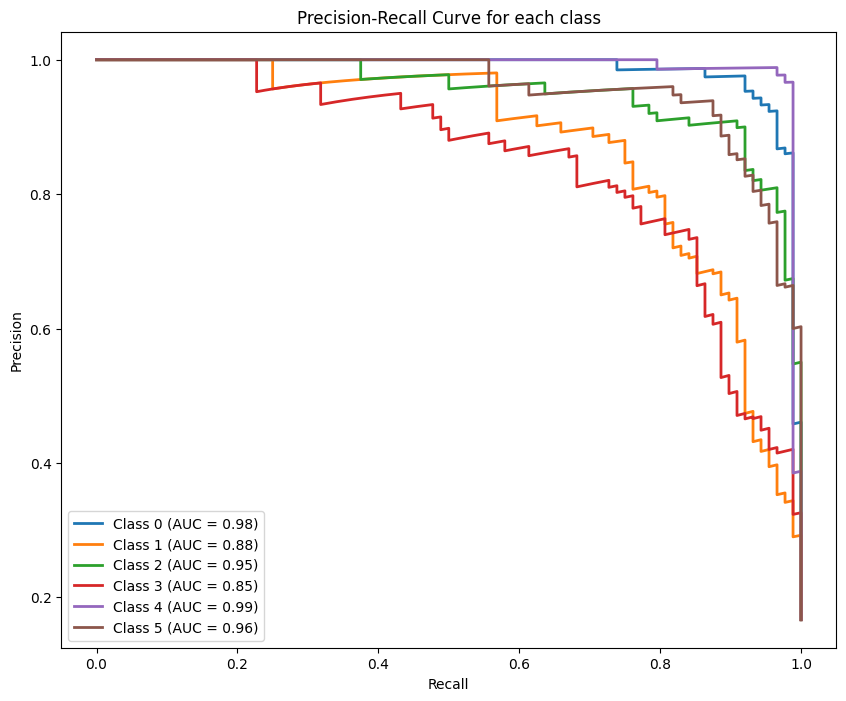

In [27]:
# Precision-Recall Curve for each class
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])
    
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend(loc="best")
plt.show()

In [28]:
#Generate predictions for the test dataset
y_pred = model_3.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

33/33 [==============================] - 10s 313ms/step


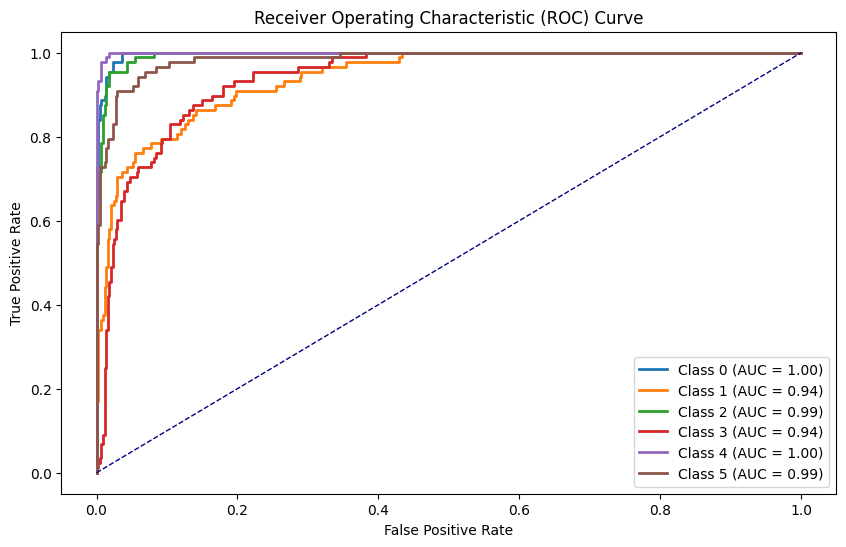

In [29]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Output Sensitivity and Specificity for each category
for idx, (sen, spec) in enumerate(zip(sensitivity_list, specificity_list)):
    print(f"Class {idx} - Sensitivity: {sen}, Specificity: {spec}")

Class 0 - Sensitivity: 0.9545454545443698, Specificity: 0.9863636363634122
Class 1 - Sensitivity: 0.7159090909082774, Specificity: 0.9749999999997785
Class 2 - Sensitivity: 0.931818181817123, Specificity: 0.9659090909088714
Class 3 - Sensitivity: 0.7499999999991477, Specificity: 0.9613636363634179
Class 4 - Sensitivity: 0.9659090909079933, Specificity: 0.9931818181815925
Class 5 - Sensitivity: 0.9204545454534995, Specificity: 0.9659090909088714


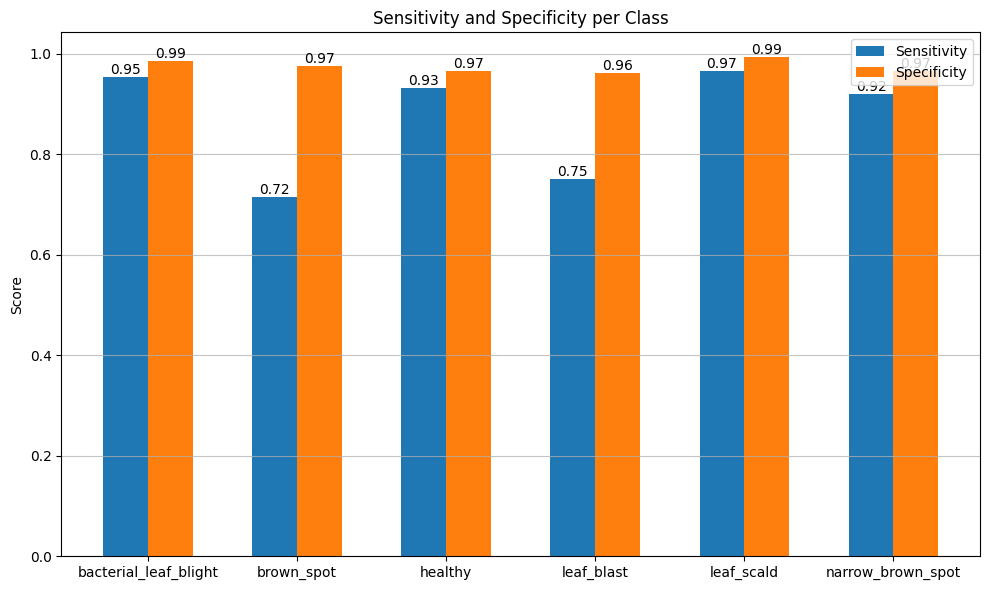

In [33]:
# 设置图形的宽度和位置  
N = len(sensitivity_list)  
ind = np.arange(N)  
width = 0.3  # 每个条形图的宽度  
  
# 绘制灵敏度的条形图  
plt.figure(figsize=(10, 6))  
sensitivity_bars = plt.bar(ind, sensitivity_list, width, label='Sensitivity')  
  
# 绘制特异度的条形图（注意：位置需要偏移以避免重叠）  
specificity_bars = plt.bar(ind + width, specificity_list, width, label='Specificity')  
   
plt.xticks(ind + width / 2, classes)  
  
# 设置x轴的标签为类别索引（如果没有具体的类标签列表）  
# plt.xticks(ind + width / 2, range(1, N + 1))  
  
# 设置y轴的标签  
plt.ylabel('Score')  
  
# 添加标题  
plt.title('Sensitivity and Specificity per Class')  
  
# 添加图例  
plt.legend()  
  
# 显示网格线  
plt.grid(axis='y', alpha=0.75)  
  
# 调整x轴和y轴的边距，以确保条形图完全可见  
plt.tight_layout()  
  
# 为每个条形添加数字标签  
def add_value_labels(bars, values):  
    for bar, value in zip(bars, values):  
        height = bar.get_height()  
        plt.text(bar.get_x() + bar.get_width() / 2, height,  
                 '{:.2f}'.format(value),  
                 ha='center', va='bottom')  
  
add_value_labels(sensitivity_bars, sensitivity_list)  
add_value_labels(specificity_bars, specificity_list)  
  
# 显示图形  
plt.show()

In [34]:
# Evaluate the performance of the model
evaluate = model_3.evaluate(
    test_generator, 
    steps = test_generator.n // BATCH_SIZE, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

33/33 [==============================] - 11s 331ms/step - loss: 0.3551 - accuracy: 0.8674
Accuracy Test : 0.8674242496490479
